In [1]:
import matplotlib.pyplot as plt

plt.rcParams['image.cmap'] = 'inferno'
plt.rcParams["font.family"] = "serif"
plt.rcParams["image.origin"] = 'lower'
plt.rcParams['figure.dpi'] = 90

In [2]:
import jax.numpy as np
import dLux as dl

# Define the parameters of the optical system
aperture_diameter = 1.0  # meters
pixel_scale       = 2e-7 # Radians per pixel of the detector
aperture_npixels  = 256  # Number of pixels representing the wavefront
detector_npixels  = 64   # Number of pixels in the detector

# Define our Optical configuration as a list of layers
layers = [
    # Create a wavefront object
    dl.CreateWavefront(aperture_npixels, aperture_diameter),

    # Create a Circular Aperture
    dl.ApertureFactory(aperture_npixels, name='Aperture'),

    # Normalise the wavefront to unity power
    dl.NormaliseWavefront(),

    # Propagate the wavefront to the detector
    dl.AngularMFT(detector_npixels, pixel_scale, name='Propagator'),
]

# Create the Optics object
optics = dl.Optics(layers)

# Propagate the wavelengths through the optics
wavelengths = np.linspace(1e-6, 1.2e-6, 5)
psf = optics.propagate(wavelengths)

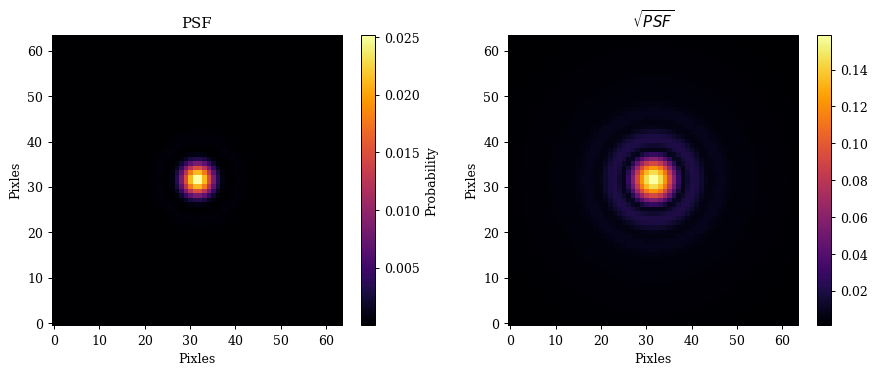

In [3]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.title("PSF")
plt.imshow(psf)
plt.xlabel('Pixles')
plt.ylabel('Pixles')
cbar = plt.colorbar()
cbar.set_label('Probability')

plt.subplot(1, 2, 2)
plt.title("$\sqrt{PSF}$")
plt.imshow(psf**0.5)
plt.xlabel('Pixles')
plt.ylabel('Pixles')
cbar = plt.colorbar()

plt.tight_layout()
plt.savefig("assets/simple_psf.png")

In [4]:
print(optics)

Optics(
  layers={
    'CreateWavefront':
    CreateWavefront(
      name='CreateWavefront',
      npixels=256,
      diameter=f32[],
      wavefront_type='Angular'
    ),
    'Aperture':
    StaticAperture(name='Aperture', aperture=f32[256,256]),
    'NormaliseWavefront':
    NormaliseWavefront(name='NormaliseWavefront'),
    'Propagator':
    AngularMFT(
      name='Propagator',
      inverse=False,
      npixels_out=64,
      pixel_scale_out=f32[],
      shift=f32[2],
      pixel_shift=False
    )
  }
)


In [5]:
# Oversample
oversample = 2
optics = optics.multiply("Propagator.npixels_out", oversample)
optics = optics.multiply("Propagator.pixel_scale_out", 1/oversample)

# Propagate
psf = optics.propagate(wavelengths)

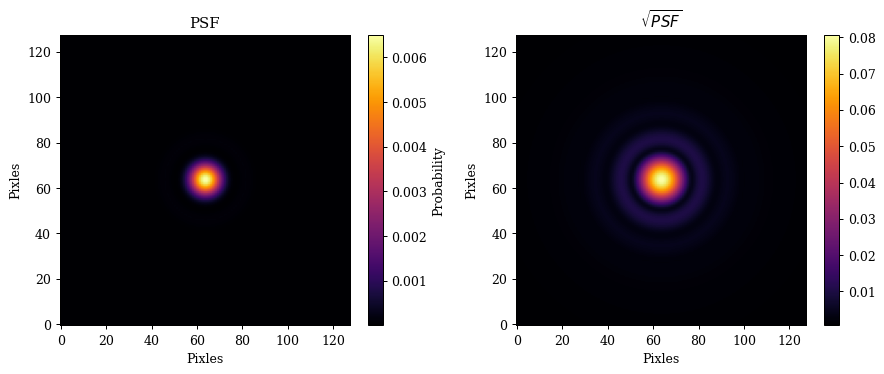

In [6]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.title("PSF")
plt.imshow(psf)
plt.xlabel('Pixles')
plt.ylabel('Pixles')
cbar = plt.colorbar()
cbar.set_label('Probability')

plt.subplot(1, 2, 2)
plt.title("$\sqrt{PSF}$")
plt.imshow(psf**0.5)
plt.xlabel('Pixles')
plt.ylabel('Pixles')
cbar = plt.colorbar()

plt.tight_layout()
plt.savefig("assets/oversampled_psf.png")

In [7]:
import jax.numpy as np
import jax.random as jr
import dLux as dl
from dLux.utils import arcseconds_to_radians as a2r

# Define the parameters of the optical system
aperture_npixels   = 256  # Number of pixels representing the wavefront
aperture_diameter  = 2.4  # meters
secondary_diameter = 0.35 # meters
strut_diameter     = 0.03 # meters
nstruts            = 4    # Number of spiders

# Calcuate values for the aperture
secondary_ratio = secondary_diameter / aperture_diameter
strut_ratio = strut_diameter / aperture_diameter

# Aberrations
zernikes = np.arange(4, 11) # 2nd and 3rd radial terms
coefficients = 5e-8 * jr.normal(jr.PRNGKey(0), zernikes.shape)

# Detector parameters
pixel_scale        = a2r(0.02) # Arcseconds per pixel of the detector
detector_npixels   = 64        # Number of pixels in the detector
oversample         = 3         # Oversample the detector


# Define our Optical configuration as a list of layers
layers = [
    # Create a wavefront object
    dl.CreateWavefront(aperture_npixels, aperture_diameter),

    # Create a HST-like Aperture
    dl.ApertureFactory(npixels         = aperture_npixels, 
                       secondary_ratio = secondary_ratio, 
                       nstruts         = nstruts, 
                       strut_ratio     = strut_ratio,
                       name            = 'Aperture'),

    # Add Zernike Aberrations
    dl.AberrationFactory(npixels      = aperture_npixels, 
                         zernikes     = zernikes, 
                         coefficients = coefficients, 
                         name         = 'Aberrations'),

    # Normalise the wavefront to unity power
    dl.NormaliseWavefront(),

    # Propagate the wavefront to the detector
    dl.AngularMFT(npixels_out     = detector_npixels * oversample, 
                  pixel_scale_out = pixel_scale / oversample, 
                  name            = 'Propagator'),
]

# Create the Optics object
optics = dl.Optics(layers)

# Propagate the wavelengths through the optics
wavelengths = np.linspace(1e-6, 1.2e-6, 5)
psf = optics.propagate(wavelengths)

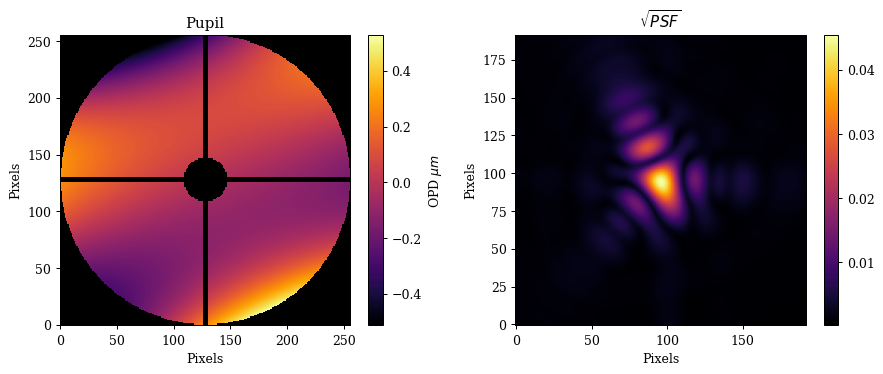

In [8]:
from matplotlib import colormaps
aberrations = optics.Aberrations.get_opd()
aperture = optics.Aperture.aperture

pupil = aberrations.at[np.where(aperture == 0.)].set(np.nan)
cmap = colormaps['inferno']
cmap.set_bad('k',1.)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.title("Pupil")
plt.imshow(pupil*1e6, cmap=cmap)
cbar = plt.colorbar()
cbar.set_label('OPD $\mu m$')
plt.xlabel("Pixels")
plt.ylabel("Pixels")

plt.subplot(1, 2, 2)
plt.imshow(psf**0.5)
plt.title("$\sqrt{PSF}$")
plt.colorbar()
plt.xlabel("Pixels")
plt.ylabel("Pixels")
plt.tight_layout()
plt.savefig("assets/hst_like_psf.png")

In [9]:
# Jitter in pixels
pixel_jitter = 3. # Pixels

# Define Detector Layers
detector_layers = [
    dl.ApplyJitter(pixel_jitter, name='Jitter'),
    dl.IntegerDownsample(oversample)
]

# Construct Detector Object
detector = dl.Detector(detector_layers)
image = detector.apply_detector(psf)

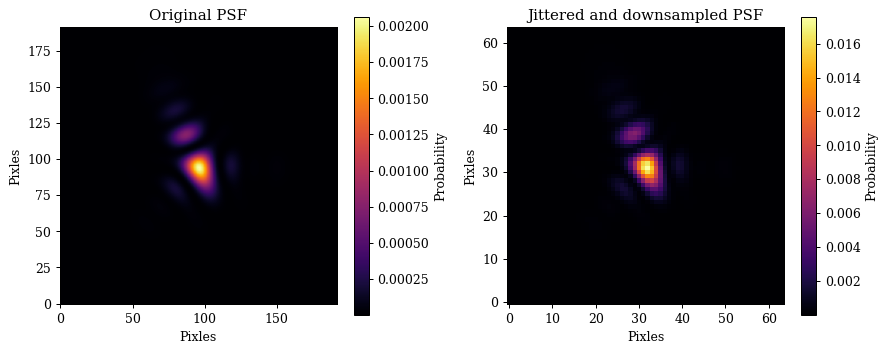

In [10]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.title("Original PSF")
plt.imshow(psf)
plt.xlabel('Pixles')
plt.ylabel('Pixles')
cbar = plt.colorbar()
cbar.set_label('Probability')

plt.subplot(1, 2, 2)
plt.title("Jittered and downsampled PSF")
plt.imshow(image)
plt.xlabel('Pixles')
plt.ylabel('Pixles')
cbar = plt.colorbar()
cbar.set_label('Probability')

plt.tight_layout()
plt.savefig("assets/image.png")

In [12]:
# Binary Source Parameters
separation = a2r(0.1)
contrast = 4
mean_flux = 1e4

# Construct Source Object
source = dl.BinarySource(separation  = separation, 
                         flux        = mean_flux,
                         contrast    = contrast, 
                         wavelengths = wavelengths,
                         name        = 'Source')

# Model the PSF
psf = optics.model(source)

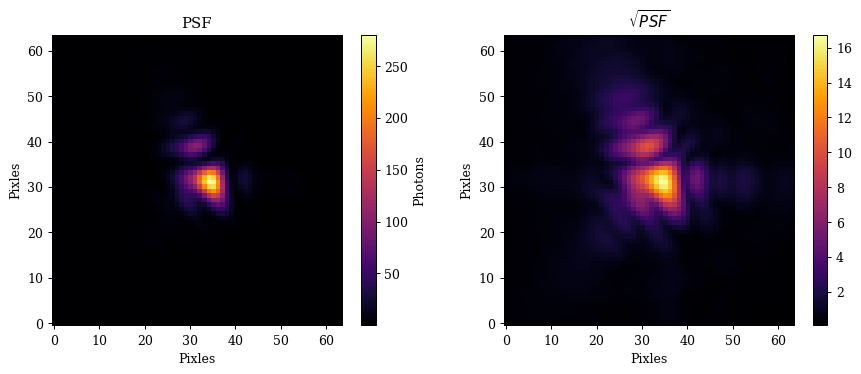

In [39]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.title("PSF")
plt.imshow(psf)
plt.xlabel('Pixles')
plt.ylabel('Pixles')
cbar = plt.colorbar()
cbar.set_label('Photons')

plt.subplot(1, 2, 2)
plt.title("$\sqrt{PSF}$")
plt.imshow(psf**0.5)
plt.xlabel('Pixles')
plt.ylabel('Pixles')
cbar = plt.colorbar()

plt.tight_layout()
plt.savefig("assets/binary_psf.png")

In [14]:
# Construct the Telescope Object
tel = dl.Instrument(optics   = optics,
                    detector = detector,
                    sources  = [source])

# Model the PSF
psf = tel.model()

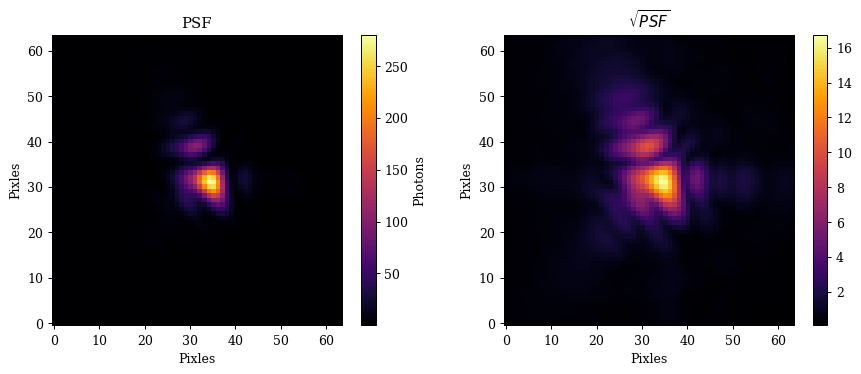

In [15]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.title("PSF")
plt.imshow(psf)
plt.xlabel('Pixles')
plt.ylabel('Pixles')
cbar = plt.colorbar()
cbar.set_label('Photons')

plt.subplot(1, 2, 2)
plt.title("$\sqrt{PSF}$")
plt.imshow(psf**0.5)
plt.xlabel('Pixles')
plt.ylabel('Pixles')
cbar = plt.colorbar()

plt.tight_layout()
plt.savefig("assets/instrument_psf.png")

In [16]:
# Construct observation Dithers
dithers = 2.5 * pixel_scale * np.array([[1, 1], [1, -1], [-1, 1], [-1, -1]])
observation = dl.Dither(dithers)

# Set the observation and model
tel = tel.set('observation', observation)
psfs = tel.observe()
data = jr.poisson(jr.PRNGKey(0), psfs)

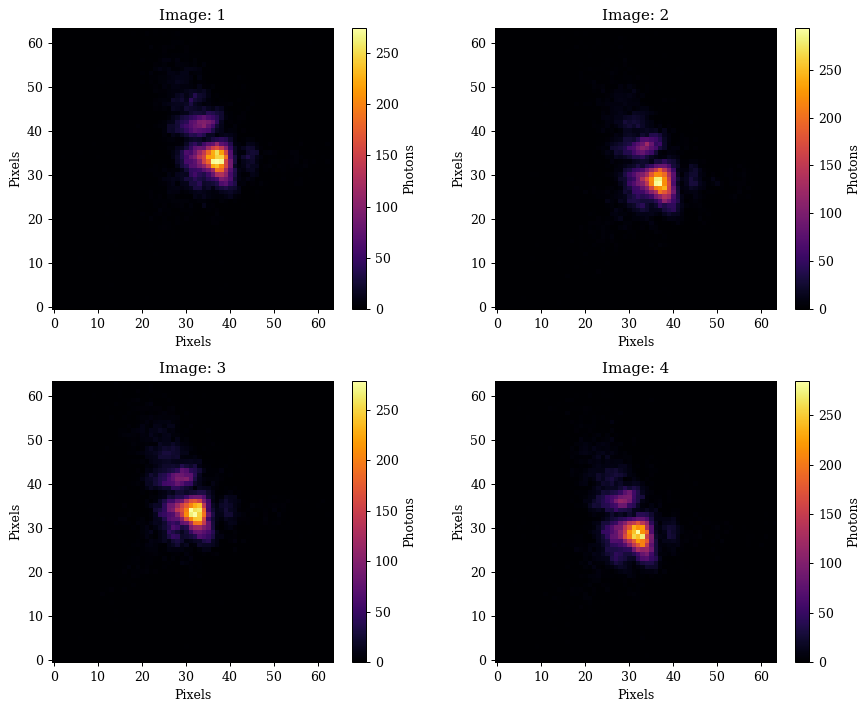

In [17]:
plt.figure(figsize=(10, 8))
for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.title(f"Image: {i+1}")
    plt.imshow(data[i])
    plt.xlabel("Pixels")
    plt.ylabel("Pixels")
    cbar = plt.colorbar()
    cbar.set_label('Photons')
plt.tight_layout()
plt.savefig("assets/data.png")

In [18]:
# Perturb values to construct initial model
model = tel.multiply('Aberrations.coefficients', 0.)
model = model.multiply('Source.separation', 1.2)
model = model.multiply('Source.flux', 0.8)

# Observe the model psfs
psfs = model.observe()

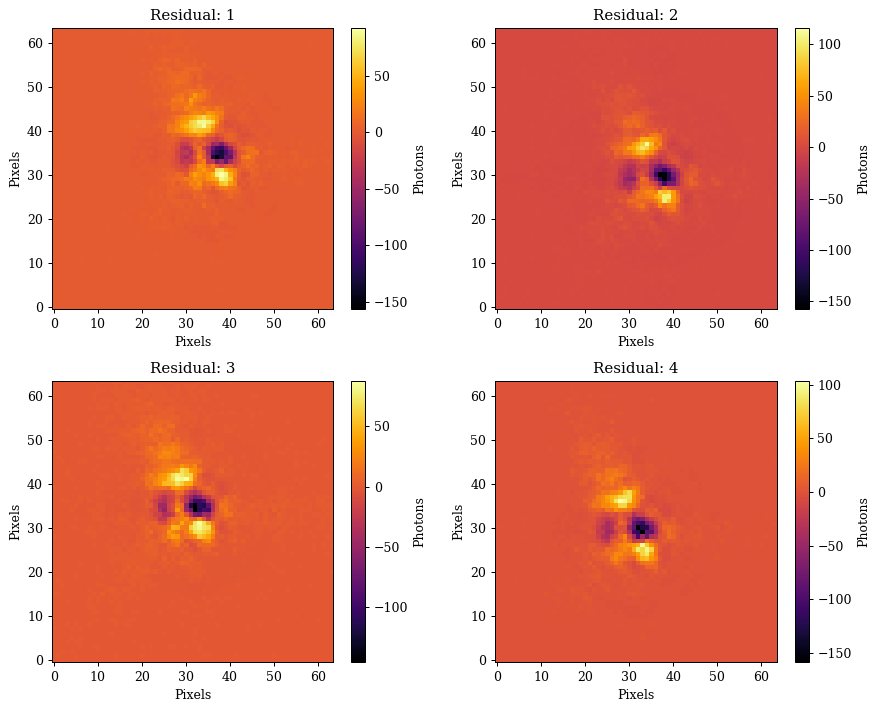

In [19]:
plt.figure(figsize=(10, 8))
for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.title(f"Residual: {i+1}")
    plt.imshow(data[i] - psfs[i])
    plt.xlabel("Pixels")
    plt.ylabel("Pixels")
    cbar = plt.colorbar()
    cbar.set_label('Photons')
plt.tight_layout()
plt.savefig("assets/residuals.png")

In [20]:
import zodiax as zdx
from jax.scipy.stats import poisson

# Define the parameters we want to recover
parameters = [
    'Aberrations.coefficients',
    'Source.separation',
    'Source.flux',
]

# Define the loss function
@zdx.filter_jit
@zdx.filter_value_and_grad(parameters)
def log_likelihood(model, data):
    psfs = model.observe()
    return - poisson.logpmf(data, psfs).sum()

# Compile
loss, grads = log_likelihood(model, data)

In [21]:
# Examine
print(loss, grads.get(parameters))

54019.42 [Array([ 5.6893770e+03, -1.4863419e+04,  9.8039580e+03, -1.1759806e+11,
        2.7824138e+11, -2.9913471e+11,  1.4453301e+11], dtype=float32), Array(2.2477005e+10, dtype=float32), Array(-1.8183861, dtype=float32)]


In [22]:
import optax

# Define learning rates
zernike_lr    = 1e-8
separation_lr = 1e-8
flux_lr       = 1e2

# Define the optimizer
optimisers = [
    optax.adam(zernike_lr),
    optax.adam(separation_lr),
    optax.adam(flux_lr),
]

# Optimise
optimiser, state = zdx.get_optimiser(model, parameters, optimisers)
losses, models = [], []
for i in range(100):
    loss, grads = log_likelihood(model, data)
    updates, state = optimiser.update(grads, state)
    model = zdx.apply_updates(model, updates)
    losses.append(loss)
    models.append(model)

# Observe the final model
final_psfs = model.observe()

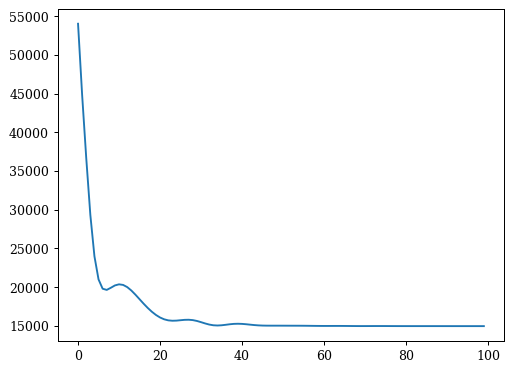

In [23]:
plt.plot(losses)

In [24]:
coeffs = np.array([m.get('Aberrations.coefficients') for m in models])
seps   = np.array([m.get('Source.separation') for m in models])
fluxes = np.array([m.get('Source.flux') for m in models])

coeff_residuals      = tel.get('Aberrations.coefficients') - coeffs
separation_residuals = tel.get('Source.separation') - seps
flux_residuals       = tel.get('Source.flux') - fluxes

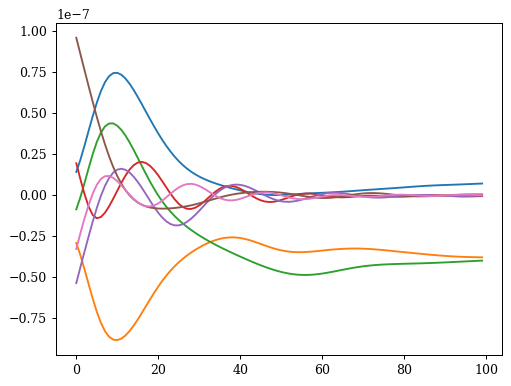

In [25]:
plt.plot(coeff_residuals)

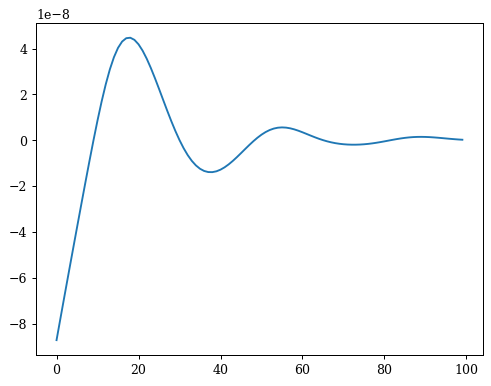

In [26]:
plt.plot(separation_residuals)


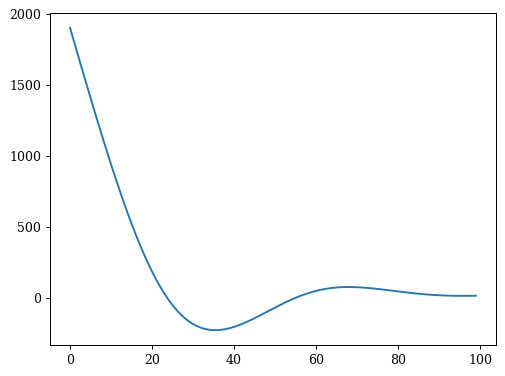

In [27]:
plt.plot(flux_residuals)

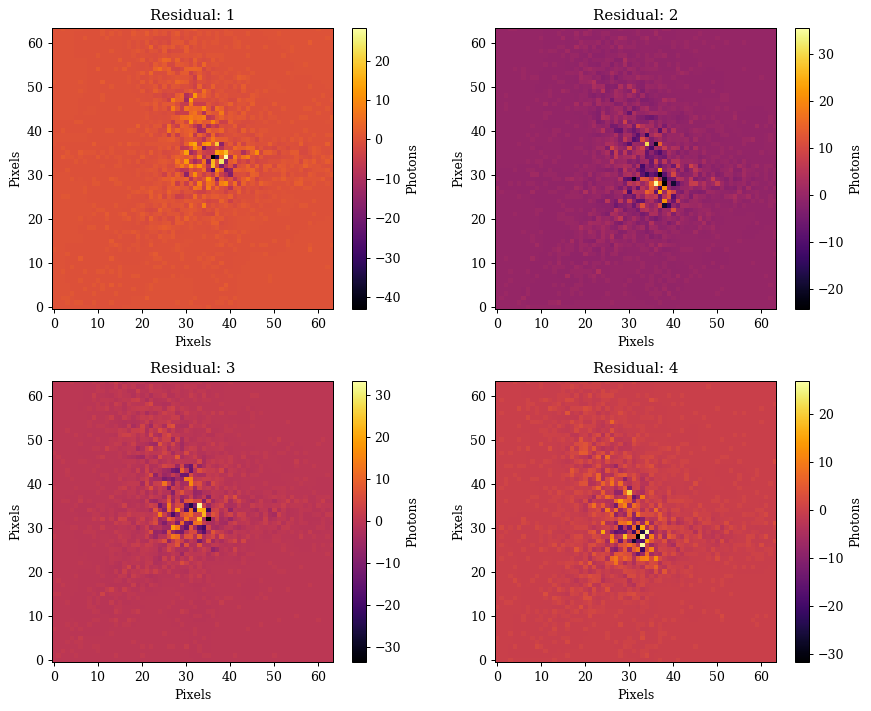

In [28]:
plt.figure(figsize=(10, 8))
for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.title(f"Residual: {i+1}")
    plt.imshow(data[i] - final_psfs[i])
    plt.xlabel("Pixels")
    plt.ylabel("Pixels")
    cbar = plt.colorbar()
    cbar.set_label('Photons')
plt.tight_layout()
plt.savefig("assets/final_residuals.png")

In [29]:
import dLux as dl

apertures = [
    dl.CircularAperture(1.),
    dl.CircularAperture(1., centre=[.5, .5]),
    dl.CircularAperture(1., shear=[.05, .05]),
    dl.CircularAperture(1., compression=[1.05, .95]),
    dl.CircularAperture(1., softening=20),
    dl.CircularAperture(1., occulting=True)
]

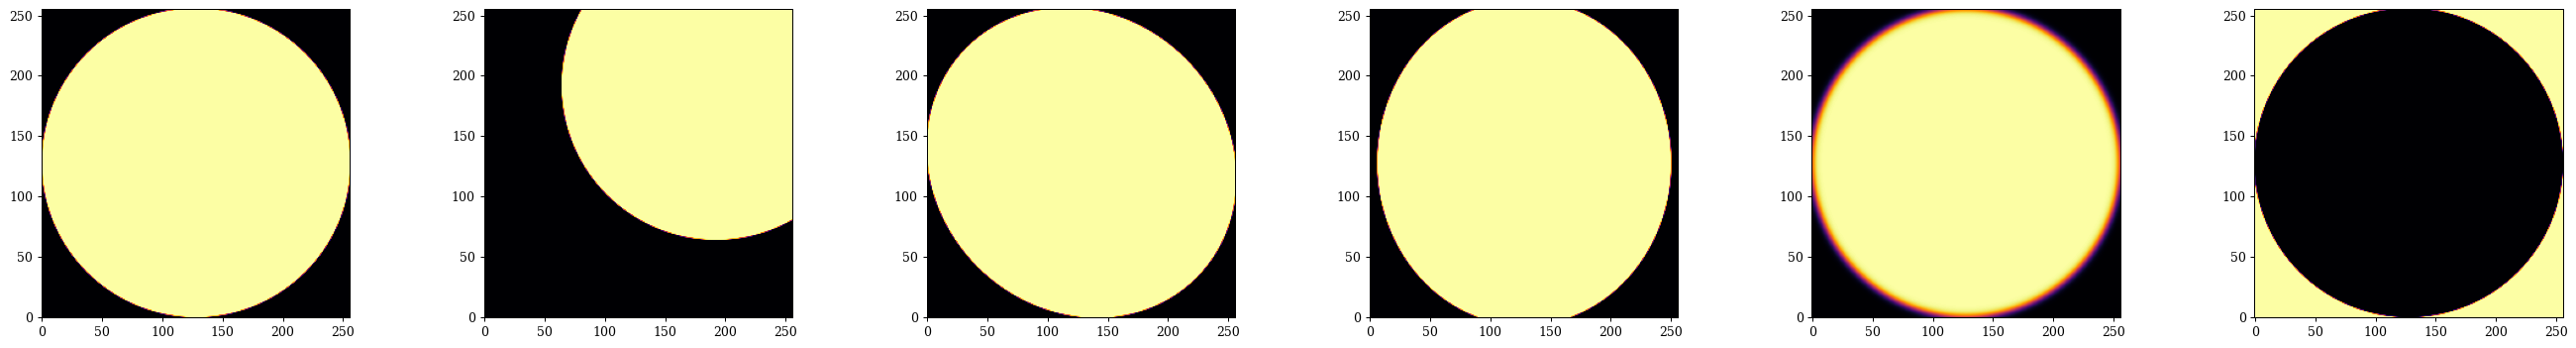

In [30]:
import matplotlib.pyplot as plt

plt.figure(figsize=(30, 4))
for i in range(len(apertures)):
    plt.subplot(1, 6, i+1)
    plt.imshow(apertures[i].get_aperture(256, 2))
plt.tight_layout()
plt.savefig("assets/apertures.png")

In [31]:
import dLux as dl
from jax import numpy as np, random as jr

# Construct Zernikes
zernikes = np.arange(4, 11)
coefficients = jr.normal(jr.PRNGKey(0), (zernikes.shape[0],))

# Construct aperture
aperture = dl.ApertureFactory(
    npixels         = 512,
    secondary_ratio = 0.1, 
    nstruts         = 4, 
    strut_ratio     = 0.01, 
    zernikes        = zernikes, 
    coefficients    = coefficients,
    name            = 'Aperture')

print(aperture)

StaticAberratedAperture(
  name='Aperture',
  aperture=f32[512,512],
  coefficients=f32[7],
  basis=f32[7,512,512]
)


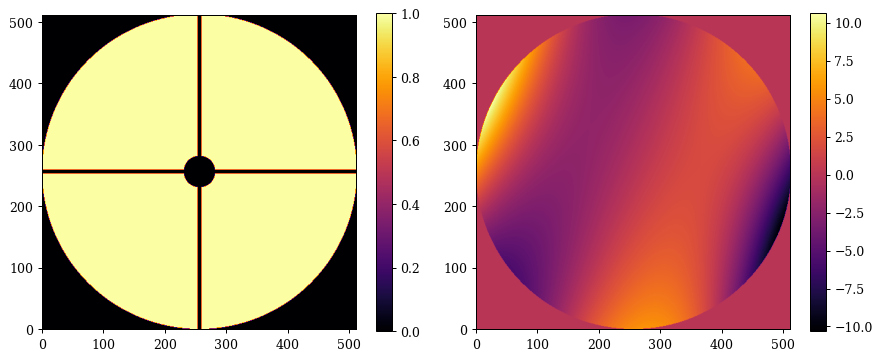

In [32]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(aperture.aperture)
plt.colorbar()

plt.subplot(1, 2, 2)
plt.imshow(aperture.opd)
plt.colorbar()
plt.tight_layout()
plt.savefig("assets/aperture_factory.png")

In [33]:
import dLux as dl

zernike_basis = dl.ZernikeBasis(np.arange(1, 7))

print(zernike_basis)

ZernikeBasis(
  zernikes=[
    Zernike(j=1, n=0, m=0, name='Piston', _k=f32[1], _c=f32[1]),
    Zernike(j=2, n=1, m=1, name='Tilt X', _k=f32[1], _c=f32[1]),
    Zernike(j=3, n=1, m=-1, name='Tilt Y', _k=f32[2], _c=f32[2]),
    Zernike(j=4, n=2, m=0, name='Defocus', _k=f32[2], _c=f32[2]),
    Zernike(j=5, n=2, m=-2, name='Astig X', _k=f32[3], _c=f32[3]),
    Zernike(j=6, n=2, m=2, name='Astig Y', _k=f32[1], _c=f32[1])
  ]
)


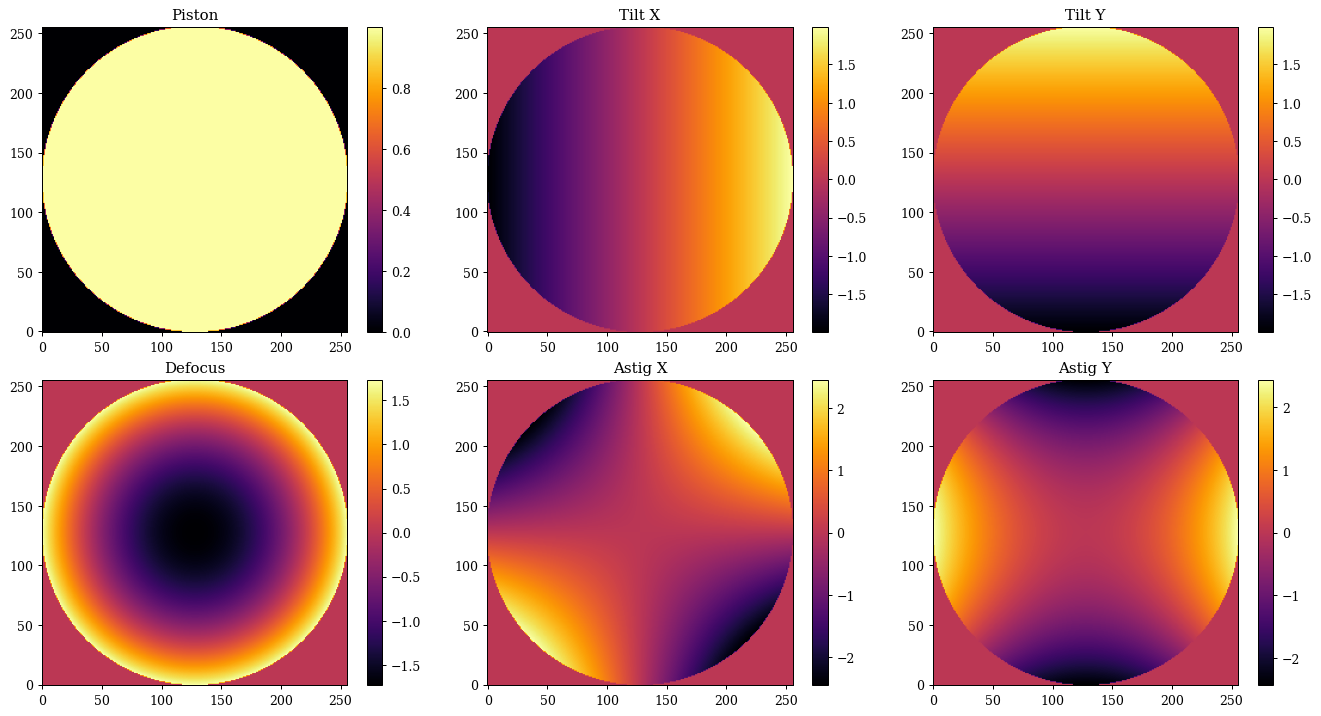

In [34]:
import matplotlib.pyplot as plt

# Calcualte coordinates
npix = 256
coords = dl.utils.get_pixel_positions((npix, npix), (2/npix, 2/npix))
basis = zernike_basis.calculate_basis(coords)

plt.figure(figsize=(15, 8))
for i in range(len(basis)):
    plt.subplot(2, 3, i+1)
    plt.title(f"{zernike_basis.zernikes[i].name}")
    plt.imshow(basis[i])
    plt.colorbar()
plt.tight_layout()
plt.savefig("assets/zernike.png")

In [35]:
import dLux as dl
from jax import numpy as np, random as jr

# Construct Zernikes
zernikes = np.arange(4, 11)
coefficients = jr.normal(jr.PRNGKey(0), (zernikes.shape[0],))

# Construct aberrations
aberrations = dl.AberrationFactory(512, zernikes=zernikes, 
                                   coefficients=coefficients)
print(aberrations)

ApplyBasisOPD(
  name='CircularAperture',
  basis=f32[7,512,512],
  coefficients=f32[7]
)


In [36]:
import dLux as dl
from jax import Array, numpy as np

class TwoFilterObservation(dl.AbstractObservation):
    filter1 : Array
    filter2 : Array

    def __init__(self, filter1, filter2):
        """Constructs the observation class"""
        super().__init__(name='TwoFilterObservation')
        self.filter1 = np.asarray(filter1, dtype=float)
        self.filter2 = np.asarray(filter2, dtype=float)

    def observe(self, instrument):
        """Models the instrument over two different band-passes"""

        # Model first PSF
        instrument = instrument.set('PointSource.wavelengths', self.filter1)
        psf1 = instrument.model()

        # Model second PSF
        instrument = instrument.set('PointSource.wavelengths', self.filter2)
        psf2 = instrument.model()

        return psf1, psf2

filter1 = 1e-6 * np.linspace(1., 1.5, 10)
filter2 = 1e-6 * np.linspace(1.5, 2., 10)
observation = TwoFilterObservation(filter1, filter2)

In [37]:
# Define the parameters of the optical system
aperture_diameter = 1.0  # meters
pixel_scale       = 2e-7 # Radians per pixel of the detector
aperture_npixels  = 256  # Number of pixels representing the wavefront
detector_npixels  = 64   # Number of pixels in the detector

# Define a simple optical system
layers = [
    dl.CreateWavefront(aperture_npixels, aperture_diameter),
    dl.ApertureFactory(aperture_npixels, name='Aperture'),
    dl.NormaliseWavefront(),
    dl.AngularMFT(detector_npixels, pixel_scale, name='Propagator'),
]

# Create the Optics object
optics = dl.Optics(layers)

# Create a Point Source
source = dl.PointSource(wavelengths=filter1)

# Create the Telescope object
telescope = dl.Instrument(optics, source, observation=observation)

# Models the two PSFs
psf1, psf2 = telescope.observe()

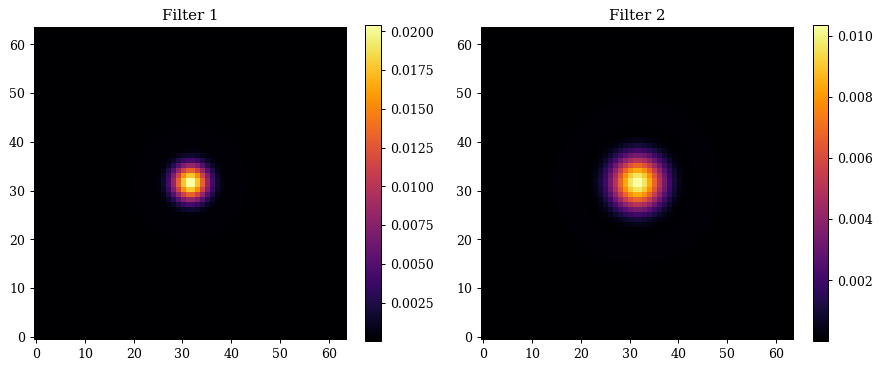

In [38]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.title("Filter 1")
plt.imshow(psf1)
plt.colorbar()

plt.subplot(1, 2, 2)
plt.title("Filter 2")
plt.imshow(psf2)
plt.colorbar()
plt.tight_layout()
plt.savefig("assets/observation.png")